In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
session = cc.database.create_session()

In [3]:
# Define experiment dictionary
from collections import OrderedDict
exptdict = OrderedDict([
    ('025degIAF', {'model':'ACCESS-OM2-025 IAF', 'expt':'025deg_jra55v13_iaf_gmredi6', # 025deg IAF run from Kiss et al. 2020
                'n_files':-1, 'itime':pd.datetime(1998,1,1),'ftime':None}),
    ('01degIAF',  {'model':'ACCESS-OM2-01 IAF',  'expt':'01deg_jra55v13_iaf', # 01deg IAF run from Kiss et al. 2020
                'n_files':-4, 'itime':pd.datetime(1998,1,1),'ftime':None}),
    ('01degRYF',  {'model':'ACCESS-OM2-01 CTRL',  'expt':'01deg_jra55v13_ryf9091', # 01deg RYF run (Qian's control)
                'n_files':-4, 'itime': '2110-01-01','ftime':'2160-01-01'}),
    ('Qian_ctrl', {'model':'ACCESS-OM2-01 CTRL', 'expt':'01deg_jra55v13_ryf9091_qian_ctrl', # 01deg Control from Li et al. 2022 
                   'n_files':None, 'itime': '2110-01-01','ftime':'2160-01-01'}),
    ('Qian_pert', {'model':'ACCESS-OM2-01 Future', 'expt':'01deg_jra55v13_ryf9091_qian_wthmp', # 01deg Full future projection from Li et al. 2022
                   'n_files':None, 'itime': '2110-01-01','ftime':'2160-01-01'}),
])

In [4]:
# Define maximum GBR region:
GBRlats = -29, -10.
GBRlons = -217.5, -202.5

SGBRlats = -24.5, -22.
SGBRlons = -208., -206.8

NGBRlats = -15., -12.
NGBRlons = -217., -214.5

# Scalar global OHC and SST (for check):

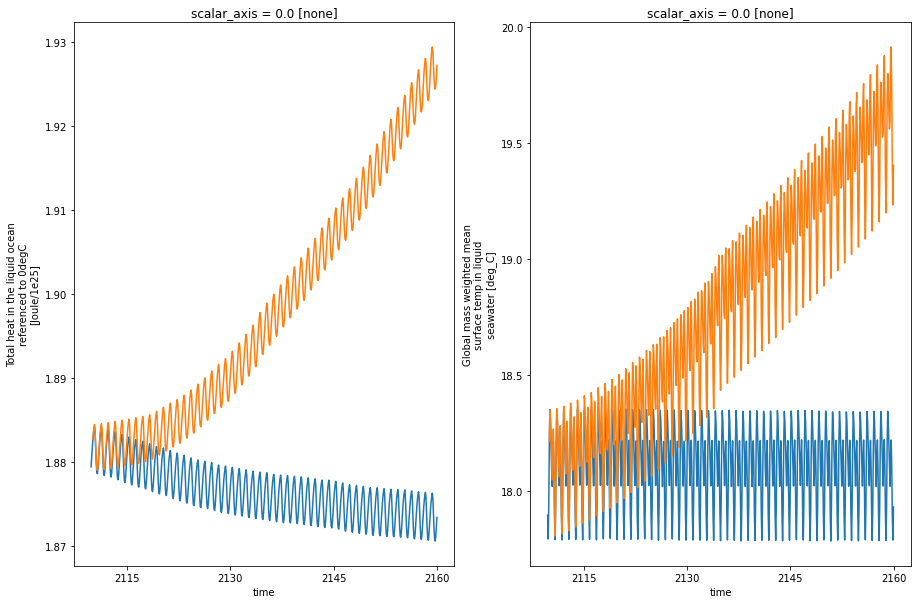

In [4]:
key = '01degRYF'
CTRL_gohc= cc.querying.getvar(exptdict[key]['expt'], 'total_ocean_heat', session,start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])
CTRL_gsst= cc.querying.getvar(exptdict[key]['expt'], 'temp_surface_ave', session,start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])
key = 'Qian_pert'
PERT_gohc= cc.querying.getvar(exptdict[key]['expt'], 'total_ocean_heat', session,start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])
PERT_gsst= cc.querying.getvar(exptdict[key]['expt'], 'temp_surface_ave', session,start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])

plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
CTRL_gohc.plot()
PERT_gohc.plot()

plt.subplot(1,2,2)
CTRL_gsst.plot()
PERT_gsst.plot()

# GBR averaged SST trends:

In [5]:
def plot_box(lons,lats,col):
    plt.plot([lons[0], lons[1], lons[1],lons[0],lons[0]],[lats[0],lats[0],lats[1],lats[1],lats[0]],'-' + col)

In [6]:
key = 'Qian_pert'
PERT_SST = cc.querying.getvar(exptdict[key]['expt'], 'surface_temp', session, frequency='1 monthly',start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime']).sel(xt_ocean=slice(GBRlons[0],GBRlons[1])).sel(yt_ocean=slice(GBRlats[0],GBRlats[1]))-273.15

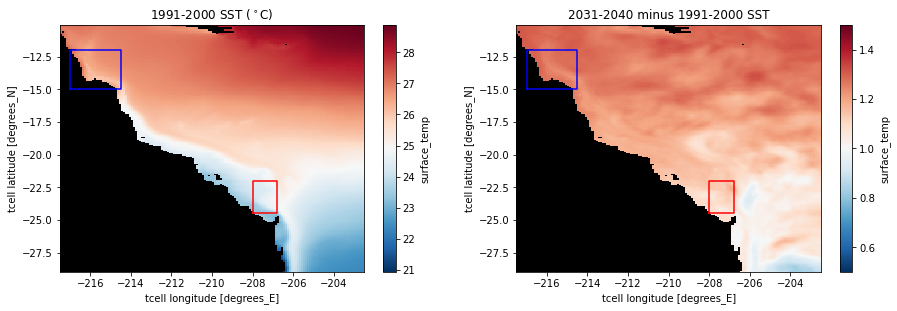

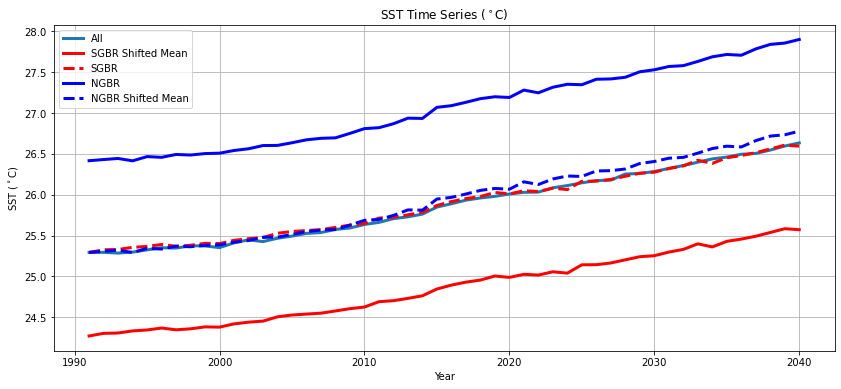

In [7]:
fig = plt.figure(figsize=(15,10),facecolor='w')

nyr = 10
sstr = '1991-2000'
fstr = '2031-2040'

plt.subplot(2,2,1)
PERT_SST.isel(time=slice(0,12*nyr)).mean('time').plot(cmap='RdBu_r')
plot_box(SGBRlons,SGBRlats,'r')
plot_box(NGBRlons,NGBRlats,'b')
plt.title(sstr + ' SST ($^\circ$C)')
plt.gca().set_facecolor('k')

plt.subplot(2,2,2)
(PERT_SST.isel(time=slice((-12*nyr-1),-1)).mean('time')-PERT_SST.isel(time=slice(0,12*nyr)).mean('time')).plot(vmin=0.5,vmax=1.5,cmap='RdBu_r') # Replace with linear trend.
plot_box(SGBRlons,SGBRlats,'r')
plot_box(NGBRlons,NGBRlats,'b')
plt.title(fstr + ' minus ' + sstr + ' SST')
plt.gca().set_facecolor('k')

fig = plt.figure(figsize=(14,6),facecolor='w')
TS = PERT_SST.mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
tvec = np.arange(1991,2041)
plt.plot(tvec,TS,label='All',linewidth=3.)
TS1 = PERT_SST.sel(xt_ocean=slice(SGBRlons[0],SGBRlons[1])).sel(yt_ocean=slice(SGBRlats[0],SGBRlats[1])).mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
plt.plot(tvec,TS1,color='r',label='SGBR Shifted Mean',linewidth=3.)
plt.plot(tvec,(TS1-TS1[0]+TS[0]),color='r',label='SGBR',linestyle='dashed',linewidth=3.)
TS2 = PERT_SST.sel(xt_ocean=slice(NGBRlons[0],NGBRlons[1])).sel(yt_ocean=slice(NGBRlats[0],NGBRlats[1])).mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
plt.plot(tvec,TS2,color='b',label='NGBR',linewidth=3.)
plt.plot(tvec,(TS2-TS2[0]+TS[0]),color='b',label='NGBR Shifted Mean',linestyle='dashed',linewidth=3.)
plt.legend()
plt.xlabel('Year')
plt.ylabel('SST ($^\circ$C)')
plt.title('SST Time Series ($^\circ$C)')
plt.grid()

# GBR averaged BT streamfunction trends:

In [8]:
key = 'Qian_pert'
PERT_TXTRANS = cc.querying.getvar(exptdict[key]['expt'], 'tx_trans_int_z', session, frequency='1 monthly',start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])
PERT_TYTRANS = cc.querying.getvar(exptdict[key]['expt'], 'ty_trans_int_z', session, frequency='1 monthly',start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])

PERT_TXTRANS = PERT_TXTRANS.sel(xu_ocean=slice(GBRlons[0],GBRlons[1])).sel(yt_ocean=slice(GBRlats[0],GBRlats[1]))
PERT_TYTRANS = PERT_TYTRANS.sel(xt_ocean=slice(GBRlons[0],GBRlons[1])).sel(yu_ocean=slice(GBRlats[0],GBRlats[1]))

In [10]:
PERT_TXTRANS

<xarray.DataArray 'tx_trans_int_z' (time: 600, yt_ocean: 202, xu_ocean: 150)>
dask.array<getitem, shape=(600, 202, 150), dtype=float32, chunksize=(1, 202, 150), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -28.94 -28.85 -28.76 ... -10.29 -10.2 -10.1
  * time      (time) object 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -217.5 -217.4 -217.3 ... -202.8 -202.7 -202.6
Attributes:
    long_name:      T-cell i-mass transport vertically summed
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_t
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 600, nv: 2)>\ndask...
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Qian Li
    email:          qian.li5@unsw.edu.au
    created:        2021-04-20
    description:    This simulation is designed for current and future climat...
    notes:          If you require any further information, feel free to cont...

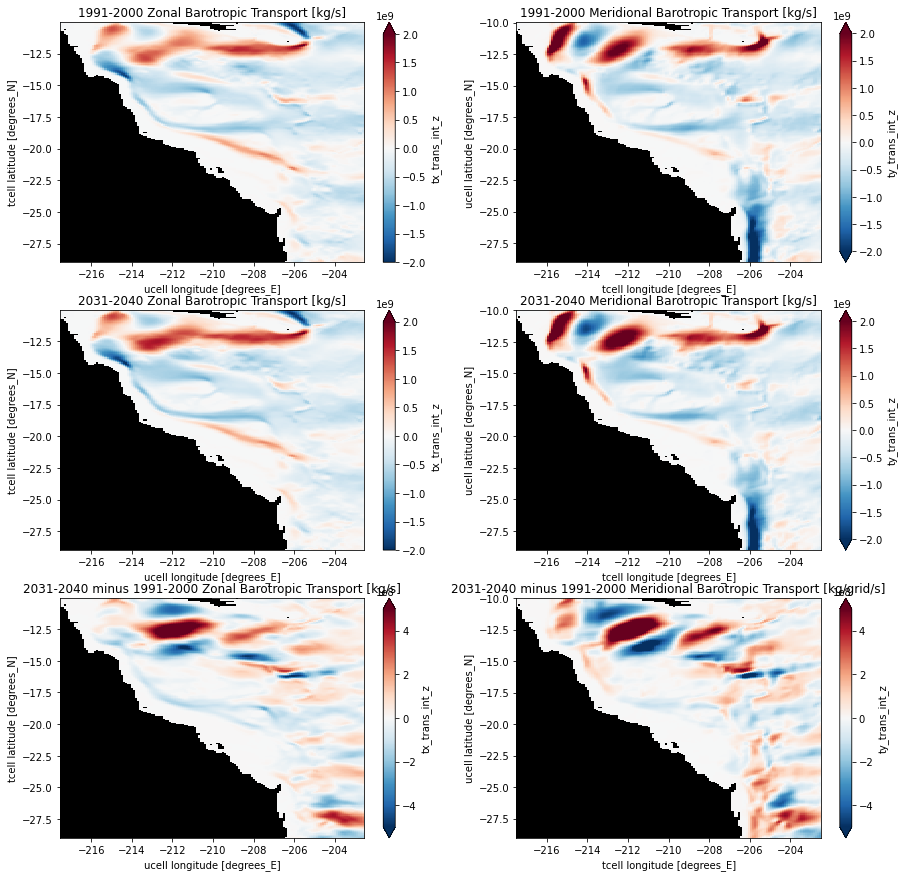

In [11]:
fig = plt.figure(figsize=(15,15),facecolor='w')

nyr = 10
sstr = '1991-2000'
fstr = '2031-2040'

plt.subplot(3,2,1)
PERT_TXTRANS.isel(time=slice(0,12*nyr)).mean('time').plot(cmap='RdBu_r',vmin=-2.e9,vmax=2.e9)
plt.title(sstr + ' Zonal Barotropic Transport [kg/s]')
plt.gca().set_facecolor('k')

plt.subplot(3,2,2)
PERT_TYTRANS.isel(time=slice(0,12*nyr)).mean('time').plot(cmap='RdBu_r',vmin=-2.e9,vmax=2.e9)
plt.title(sstr + ' Meridional Barotropic Transport [kg/s]')
plt.gca().set_facecolor('k')

plt.subplot(3,2,3)
PERT_TXTRANS.isel(time=slice((-12*nyr-1),-1)).mean('time').plot(cmap='RdBu_r',vmin=-2.e9,vmax=2.e9)
plt.title(fstr + ' Zonal Barotropic Transport [kg/s]')
plt.gca().set_facecolor('k')

plt.subplot(3,2,4)
PERT_TYTRANS.isel(time=slice((-12*nyr-1),-1)).mean('time').plot(cmap='RdBu_r',vmin=-2.e9,vmax=2.e9)
plt.title(fstr + ' Meridional Barotropic Transport [kg/s]')
plt.gca().set_facecolor('k')

plt.subplot(3,2,5)
(PERT_TXTRANS.isel(time=slice((-12*nyr-1),-1)).mean('time')-PERT_TXTRANS.isel(time=slice(0,12*nyr)).mean('time')).plot(cmap='RdBu_r',vmin=-0.5e9,vmax=0.5e9)
plt.title(fstr + ' minus ' + sstr + ' Zonal Barotropic Transport [kg/s]')
plt.gca().set_facecolor('k')

plt.subplot(3,2,6)
(PERT_TYTRANS.isel(time=slice((-12*nyr-1),-1)).mean('time')-PERT_TYTRANS.isel(time=slice(0,12*nyr)).mean('time')).plot(cmap='RdBu_r',vmin=-0.5e9,vmax=0.5e9)
plt.title(fstr + ' minus ' + sstr + ' Meridional Barotropic Transport [kg/grid/s]')
plt.gca().set_facecolor('k')

# Control state resolution plot

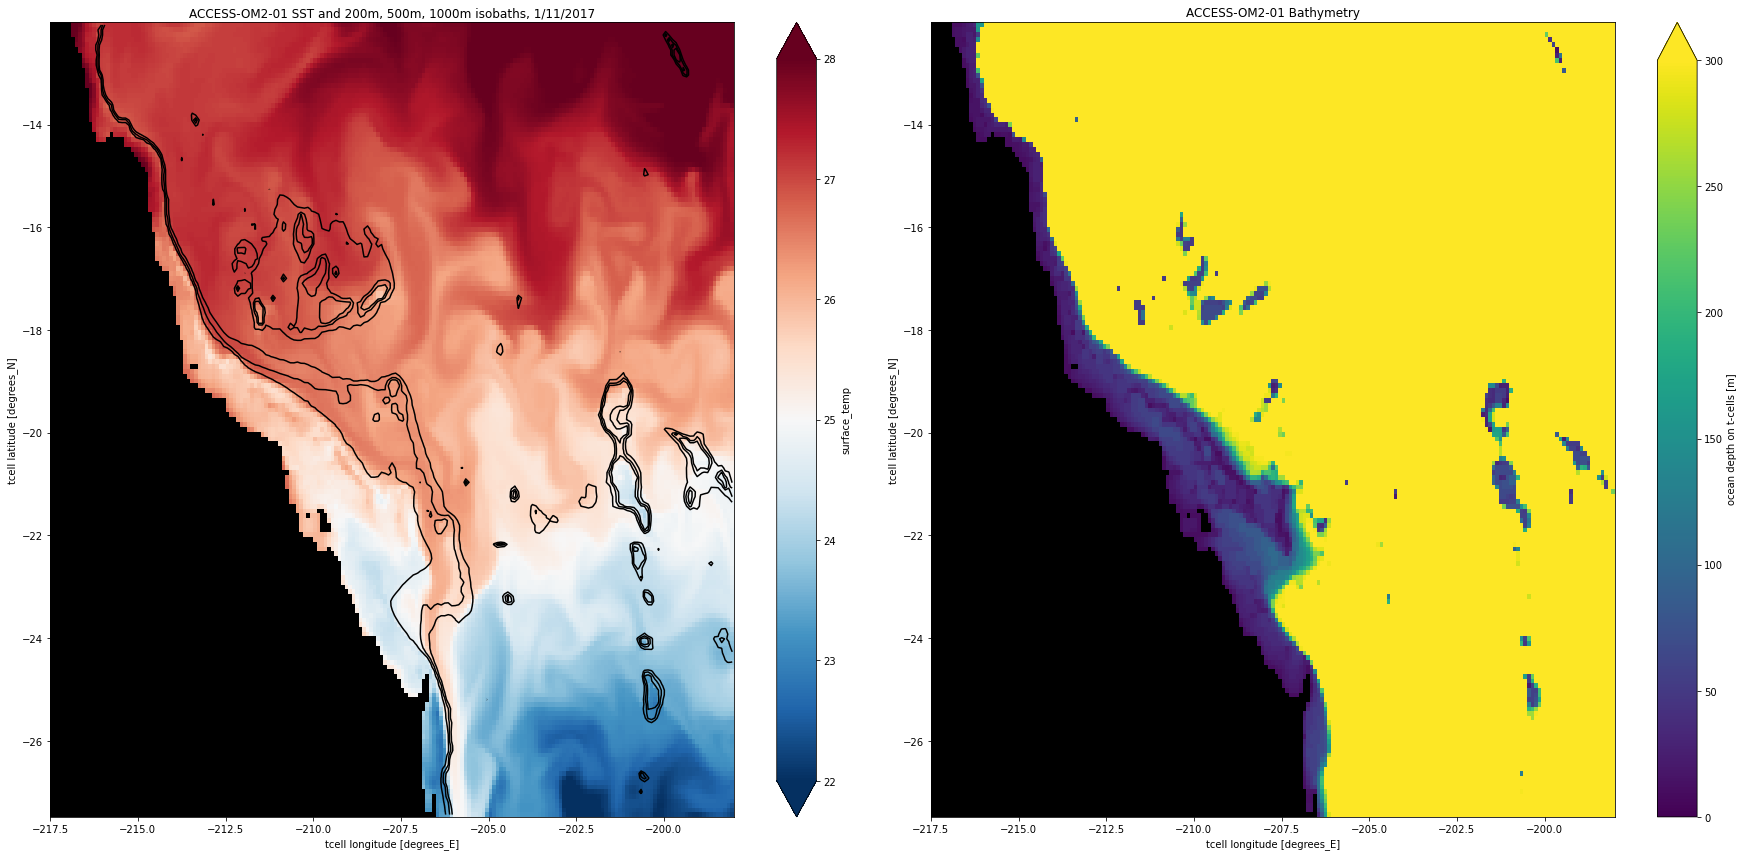

In [42]:
fig = plt.figure(figsize=(25,12),facecolor='w')

keys = ['01degIAF']#,'025degIAF','01degIAF']
for i, key in enumerate(keys):
    ax = plt.subplot(1,2,1)
    
    var = cc.querying.getvar(exptdict[key]['expt'], 'surface_temp',session, frequency='1 daily',n=exptdict[key]['n_files'],
                             start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime']).sel(xt_ocean=slice(-217.5,-198)).sel(yt_ocean=slice(-27.5,-12.))
    h = cc.querying.getvar(exptdict[key]['expt'], 'ht',session,n=-1).sel(xt_ocean=slice(-217.5,-198)).sel(yt_ocean=slice(-27.5,-12.))
    var = var.sel(time='2017-11-01')-273.15
    var.plot(ax=ax,vmin=22.,vmax=28.,cmap='RdBu_r')
    h.plot.contour(levels=[200.,500.,1000.],colors='k')
    ax.set_facecolor('k')
    ax.set_title('ACCESS-OM2-01 SST and 200m, 500m, 1000m isobaths, 1/11/2017')
    
    
    ax = plt.subplot(1,2,2)
    h.plot(ax=ax,vmin=0.,vmax=300.)
    ax.set_facecolor('k')
    ax.set_title('ACCESS-OM2-01 Bathymetry')

plt.tight_layout()
plt.savefig('GBR_SST_ACCESS-OM2-01.png',dpi=150)